# Imports 

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
 
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200921/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200923/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/'

os.system("mkdir -p "+ plotDir)

0

# Signal part

In [5]:
# masses = np.array([127, 150, 175, 200, 250, 300, 400])
masses = np.array([ 200 ])


# directory
# home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v13/MC_Fall17/normalized/'
# home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v14/MC_Fall17/normalized/'
# home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v16/MC_Fall17/normalized/'
home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v15/MC_Fall17/normalized/'
# file names
fnames = {}
# get all the trees
tree = OrderedDict()

for mass in masses:
    fnames[str(mass)] = 'n3n2-n1-hbb-hbb_mh'+str(mass)+'_pl1000_ev100000_1pb_weighted.root'
#     fnames[str(mass)] = 'n3n2-n1-hbb-hbb_mh'+str(mass)+'_pl10000_ev100000_1pb_weighted.root'

    print(home_dir+fnames[str(mass)])

    root_dir = uproot.open(home_dir+fnames[str(mass)])
#     tree[str(mass)] = root_dir['SusyLLPTree']
    tree[str(mass)] = root_dir['SusyLLPSigEffTree']

    print ('Open ready')
    print(mass)
    print ('Tree ready')
    print(tree[str(mass)], tree)
    v = tree[str(mass)]
#     jet_amax = v['jetGammaMax_ET'].array()
    jet_amax = v['gLLP_ctau'].array()
    print(jet_amax[:10])
    jet_amax = v['weight'].array()
    print(jet_amax[:10])
    print(np.unique(jet_amax))
     


/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v15/MC_Fall17/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root
Open ready
200
Tree ready
<TTree b'SusyLLPSigEffTree' at 0x7fbd7f6c5dd8> OrderedDict([('200', <TTree b'SusyLLPSigEffTree' at 0x7fbd7f6c5dd8>)])
[[195.00415  276.53256 ]
 [ 93.86968  100.84486 ]
 [ 82.28342   17.086859]
 [148.26236  155.68602 ]
 [386.55975    9.112002]
 [ 97.657585  42.1076  ]
 [139.32481   22.043077]
 [160.60211    4.173067]
 [229.04637   20.21918 ]
 [ 72.456314 117.97593 ]]
[8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06
 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06]
[8.116029e-06]


In [6]:
for k,v in tree.items():
    print(k,v)

200 <TTree b'SusyLLPSigEffTree' at 0x7fbd7f6c5dd8>


# boosted region

In [82]:
# trg_path=310
trg_path=467
njet_cut=-1
met_cut=200
mdphi_cut=0.5
veto=1

fatjet=0
# fatjet_pt_cut=250
# fatjet_pt_cut=300

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6


trg_jet_met = {}
trg_jet_nj = {}
trg_jet_mt = {}
trg_jet_ht = {}
trg_jet_mdphi = {}
trg_jet_w = {} 
trg_jet_puw = {} 

trg_fatjet_pt = {}
trg_fatjet_eta = {}

trg_jet_pt = {}
trg_jet_eta = {}
trg_jet_e = {}
trg_jet_phi = {}

trg_jet_chef = {}
trg_jet_muef = {}
trg_jet_eleef = {}
trg_jet_phoef = {}

trg_jet_nhef = {}
trg_jet_cemef = {}
trg_jet_nemef = {}

trg_jet_tmf = {}
trg_jet_dr = {}
trg_jet_time = {}

trg_jet_csv = {}

jet_csv_cut=0.5803
trg_jet_csvl = {}
trg_jet_nb = {}

ECAL_R=129.0 #cm
EB_Z=268.3 #cm
trg_jet_ctau = {}
trg_jet_eb = {}
trg_jet_tagged = {}

for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
#     mt = v['MT_'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
#     llp_r = v['gLLP_decay_vertex_r'].array()
#     llp_z = v['gLLP_decay_vertex_z'].array()
    llp_tagged = v['gLLP_tagged'].array()
    llp_eb = v['gLLP_eb'].array()
    llp_ctau = v['gLLP_ctau'].array()

#     
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    #jet var
    fatpt = v['fatJetPt'].array()
    fateta = v['fatJetEta'].array()
    
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    
    chef = v['jetChargedHadronEnergyFraction'].array()
    muef = v['jetMuonEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    
#     nhef = v['jetNeutralHadronEnergyFraction'].array()
#     cemef = v['jetNeutralEMEnergyFraction'].array()
#     nemef = v['jetNeutralEMEnergyFraction'].array()
 
    tmf = v['jetGammaMax_ET'].array()
    dr = v['jetMinDeltaRPVTracks'].array()
    time = v['jetTime'].array()
    
    csv = v['jetCSV'].array()

    weight = v['weight'].array()
    
    #pileup weights
#     if 'background' in k:
    if 'Data' not in k:
        PUweight = v['pileupWeight'].array()
        
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if '2016' not in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
    basic_met_str = np.logical_and(basic_met_str, nlep==0)
    
    if veto==1:
        basic_met_str = np.logical_and(basic_met_str, nmu==0)
        basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==0)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut)  
    
    basic_fatjet_str = np.logical_and(abs(fateta)<jet_eta_cut, fatpt>jet_pt_cut)   

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
    
#     print(fatpt[fatpt>fatjet_pt_cut].count()[:10])
#     print(fatpt[:10])
#     print(fatpt[fatpt>fatjet_pt_cut][:10])
#     fatjet_str = np.logical_and(1, fatpt[fatpt>fatjet_pt_cut].count()==0)
    fatjet_str = np.logical_and(1, fatpt[fatpt>fatjet_pt_cut].count()>0)
    if fatjet:
        met_trg_str = np.logical_and(basic_met_str, fatjet_str)
#     if 'H(bb)' in k:
#         met_trg_str = np.logical_and(basic_met_str, np.sum(llp_eb,axis = 1) > 0) 

    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_ht[k] = ht[met_trg_str]
    trg_jet_mdphi[k] = mdphi[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]
#     if 'background' in k:
    if 'Data' not in k:
        trg_jet_puw[k] = PUweight[met_trg_str]
    trg_jet_ctau[k] = llp_ctau[met_trg_str]
    trg_jet_eb[k] = llp_eb[met_trg_str]
    trg_jet_tagged[k] = llp_tagged[met_trg_str]
        

    trg_fatjet_pt[k] = fatpt[basic_fatjet_str][met_trg_str]
    trg_fatjet_eta[k] = fatpt[basic_fatjet_str][met_trg_str]
    
#     trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
#     trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
#     trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
#     trg_jet_e[k] = e[basic_jet_str][met_trg_str]

# #     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
# #     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
# #     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
# #     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
# #     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
# #     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
#     trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
#     trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
#     trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
#     trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
# #     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
# #     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
#     trg_jet_time[k] = time[basic_jet_str][met_trg_str]
#     trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
#     trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
# #     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

#     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]

    #clean up
#     trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_ht[k] = trg_jet_ht[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_mdphi[k] = trg_jet_mdphi[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>njet_cut]
# #     if 'background' in k:
#     if 'Data' not in k:
#         trg_jet_puw[k] = trg_jet_puw[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_ctau[k] = trg_jet_ctau[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_eb[k] = trg_jet_eb[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_tagged[k] = trg_jet_tagged[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_phi[k] = trg_jet_phi[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_eta[k] = trg_jet_eta[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_e[k] = trg_jet_e[k][trg_jet_pt[k].count()>njet_cut]

# #     trg_jet_nhm[k] = trg_jet_nhm[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_chm[k] = trg_jet_chm[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_mum[k] = trg_jet_mum[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_elem[k] = trg_jet_elem[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_phom[k] = trg_jet_phom[k][trg_jet_pt[k].count()>njet_cut]
    
# #     trg_jet_nhef[k] = trg_jet_nhef[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_muef[k] = trg_jet_muef[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_eleef[k] = trg_jet_eleef[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_phoef[k] = trg_jet_phoef[k][trg_jet_pt[k].count()>njet_cut]
    
# #     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    
# #     trg_jet_nrec[k] = trg_jet_nrec[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_time[k] = trg_jet_time[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_amax[k] = trg_jet_amax[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_csvl[k] = trg_jet_csv[k][trg_jet_csv[k]>jet_csv_cut]
#     trg_jet_nb[k] = trg_jet_csvl[k].count()

#     trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>njet_cut]

    #print out check


    print(len(trg_jet_w[k]))
    print(len(trg_jet_puw[k]))
#     print(len(trg_jet_pt[k]))
    print(len(trg_fatjet_pt[k]))
    print(len(trg_jet_ctau[k]))
    print(len(trg_jet_eb[k]))
    print(len(trg_jet_tagged[k]))
#     print(trg_jet_ctau[k][:10])
#     print(trg_jet_pt[k][:10])
#     print(trg_fatjet_pt[k][:10])
#     print(trg_jet_eb[k][:10])

    

127 <TTree b'SusyLLPTree' at 0x7fab784fbe10>
(2756,)
2415
2415
2415
2415
2415
2415
150 <TTree b'SusyLLPTree' at 0x7fab7861ee80>
(2908,)
2522
2522
2522
2522
2522
2522
175 <TTree b'SusyLLPTree' at 0x7fab785e1b00>
(3011,)
2586
2586
2586
2586
2586
2586
200 <TTree b'SusyLLPTree' at 0x7fab786ef2e8>
(3595,)
3021
3021
3021
3021
3021
3021
250 <TTree b'SusyLLPTree' at 0x7fab77b6fd68>
(5201,)
4282
4282
4282
4282
4282
4282
300 <TTree b'SusyLLPTree' at 0x7fab7737bba8>
(7429,)
6145
6145
6145
6145
6145
6145
400 <TTree b'SusyLLPTree' at 0x7fab7730e160>
(13315,)
10994
10994
10994
10994
10994
10994


In [85]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Weight' , 'ALL Yield', 'ALL Error'])
for k,v in tree.items():
 
    lumi=137000
 
    EventW = [x*y for x,y in zip(trg_jet_w[k],trg_jet_puw[k])]
    EventWsq = [x*x  for x in EventW]
    row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2) ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+--------+-----------------+-----------+-----------+
| Sample |      Weight     | ALL Yield | ALL Error |
+--------+-----------------+-----------+-----------+
|  127   | [5.6951445e-05] |  19610.89 |   425.78  |
|  150   | [2.1877613e-05] |   7913.7  |   167.97  |
|  175   | [1.5398517e-05] |  5664.23  |   118.97  |
|  200   |  [8.116029e-06] |  3459.98  |    67.4   |
|  250   | [5.1101733e-06] |  3114.25  |   50.91   |
|  300   | [1.8683509e-06] |  1636.28  |   22.27   |
|  400   |  [6.086827e-07] |   955.56  |    9.73   |
+--------+-----------------+-----------+-----------+


In [86]:
table_txt = table.get_string()
with open(plotDir+'/PreviousSignalSummaryTable.txt','w') as file:
    file.write(table_txt)

# Resolved + Boosted

In [97]:
fatjet_pt_cut=250
# fatjet_pt_cut=300


In [98]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Weight' , 'AK8 Yield', 'AK8 Error'])
for k,v in tree.items():
 
    lumi=137000
 
    EventW = [x*y for x,y in zip(trg_jet_w[k][trg_fatjet_pt[k][trg_fatjet_pt[k]>fatjet_pt_cut].count()>0],trg_jet_puw[k][trg_fatjet_pt[k][trg_fatjet_pt[k]>fatjet_pt_cut].count()>0])]
    EventWsq = [x*x  for x in EventW]
    row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2) ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+--------+-----------------+-----------+-----------+
| Sample |      Weight     | AK8 Yield | AK8 Error |
+--------+-----------------+-----------+-----------+
|  127   | [5.6951445e-05] |  7761.82  |   267.76  |
|  150   | [2.1877613e-05] |  3479.45  |   111.14  |
|  175   | [1.5398517e-05] |   2702.0  |   82.27   |
|  200   |  [8.116029e-06] |  1765.61  |   47.94   |
|  250   | [5.1101733e-06] |  1766.07  |   38.28   |
|  300   | [1.8683509e-06] |   959.95  |   17.02   |
|  400   |  [6.086827e-07] |   581.23  |    7.58   |
+--------+-----------------+-----------+-----------+


In [99]:
table_txt = table.get_string()
with open(plotDir+'/Boosted_fatjet'+str(fatjet_pt_cut)+'_SignalSummaryTable.txt','w') as file:
    file.write(table_txt)

In [100]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Weight' , 'AK4 Yield', 'AK4 Error'])
for k,v in tree.items():
 
    lumi=137000
 
    EventW = [x*y for x,y in zip(trg_jet_w[k][trg_fatjet_pt[k][trg_fatjet_pt[k]>fatjet_pt_cut].count()==0],trg_jet_puw[k][trg_fatjet_pt[k][trg_fatjet_pt[k]>fatjet_pt_cut].count()==0])]
    EventWsq = [x*x  for x in EventW]
    row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2) ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+--------+-----------------+-----------+-----------+
| Sample |      Weight     | AK4 Yield | AK4 Error |
+--------+-----------------+-----------+-----------+
|  127   | [5.6951445e-05] |  11849.07 |   331.05  |
|  150   | [2.1877613e-05] |  4434.25  |   125.94  |
|  175   | [1.5398517e-05] |  2962.23  |   85.94   |
|  200   |  [8.116029e-06] |  1694.36  |   47.38   |
|  250   | [5.1101733e-06] |  1348.18  |   33.57   |
|  300   | [1.8683509e-06] |   676.33  |   14.37   |
|  400   |  [6.086827e-07] |   374.32  |    6.1    |
+--------+-----------------+-----------+-----------+


In [101]:
table_txt = table.get_string()
with open(plotDir+'/ResolvedAll_fatjet'+str(fatjet_pt_cut)+'_SignalSummaryTable.txt','w') as file:
    file.write(table_txt)

In [102]:
# trg_path=310
trg_path=467
njet_cut=-1
met_cut=200
mdphi_cut=0.5
veto=1

fatjet=0
# fatjet_pt_cut=250
# fatjet_pt_cut=300

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6


trg_jet_met = {}
trg_jet_nj = {}
trg_jet_mt = {}
trg_jet_ht = {}
trg_jet_mdphi = {}
trg_jet_w = {} 
trg_jet_puw = {} 

trg_fatjet_pt = {}
trg_fatjet_eta = {}

trg_jet_pt = {}
trg_jet_eta = {}
trg_jet_e = {}
trg_jet_phi = {}

trg_jet_chef = {}
trg_jet_muef = {}
trg_jet_eleef = {}
trg_jet_phoef = {}

trg_jet_nhef = {}
trg_jet_cemef = {}
trg_jet_nemef = {}

trg_jet_tmf = {}
trg_jet_dr = {}
trg_jet_time = {}

trg_jet_csv = {}

jet_csv_cut=0.5803
trg_jet_csvl = {}
trg_jet_nb = {}

ECAL_R=129.0 #cm
EB_Z=268.3 #cm
trg_jet_ctau = {}
trg_jet_eb = {}
trg_jet_tagged = {}

for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
#     mt = v['MT_'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
#     llp_r = v['gLLP_decay_vertex_r'].array()
#     llp_z = v['gLLP_decay_vertex_z'].array()
    llp_tagged = v['gLLP_tagged'].array()
    llp_eb = v['gLLP_eb'].array()
    llp_ctau = v['gLLP_ctau'].array()

#     
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    #jet var
    fatpt = v['fatJetPt'].array()
    fateta = v['fatJetEta'].array()
    
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    
    chef = v['jetChargedHadronEnergyFraction'].array()
    muef = v['jetMuonEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    
#     nhef = v['jetNeutralHadronEnergyFraction'].array()
#     cemef = v['jetNeutralEMEnergyFraction'].array()
#     nemef = v['jetNeutralEMEnergyFraction'].array()
 
    tmf = v['jetGammaMax_ET'].array()
    dr = v['jetMinDeltaRPVTracks'].array()
    time = v['jetTime'].array()
    
    csv = v['jetCSV'].array()

    weight = v['weight'].array()
    
    #pileup weights
#     if 'background' in k:
    if 'Data' not in k:
        PUweight = v['pileupWeight'].array()
        
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if '2016' not in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
    basic_met_str = np.logical_and(basic_met_str, nlep==0)
    
    if veto==1:
        basic_met_str = np.logical_and(basic_met_str, nmu==0)
        basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==0)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut)  
    
    basic_fatjet_str = np.logical_and(abs(fateta)<jet_eta_cut, fatpt>jet_pt_cut)   

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
    
#     print(fatpt[fatpt>fatjet_pt_cut].count()[:10])
#     print(fatpt[:10])
#     print(fatpt[fatpt>fatjet_pt_cut][:10])
    fatjet_str = np.logical_and(1, fatpt[fatpt>fatjet_pt_cut].count()==0)
#     fatjet_str = np.logical_and(1, fatpt[fatpt>fatjet_pt_cut].count()>0)
    if fatjet:
        met_trg_str = np.logical_and(basic_met_str, fatjet_str)
#     if 'H(bb)' in k:
#         met_trg_str = np.logical_and(basic_met_str, np.sum(llp_eb,axis = 1) > 0) 

    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_ht[k] = ht[met_trg_str]
    trg_jet_mdphi[k] = mdphi[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]
#     if 'background' in k:
    if 'Data' not in k:
        trg_jet_puw[k] = PUweight[met_trg_str]
    trg_jet_ctau[k] = llp_ctau[met_trg_str]
    trg_jet_eb[k] = llp_eb[met_trg_str]
    trg_jet_tagged[k] = llp_tagged[met_trg_str]
        

    trg_fatjet_pt[k] = fatpt[basic_fatjet_str][met_trg_str]
    trg_fatjet_eta[k] = fatpt[basic_fatjet_str][met_trg_str]
    
    trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
    trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
    trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
    trg_jet_e[k] = e[basic_jet_str][met_trg_str]

#     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
#     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
#     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
#     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
#     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
#     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
    trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
    trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
    trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
    trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
#     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
#     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
    trg_jet_time[k] = time[basic_jet_str][met_trg_str]
    trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
    trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
#     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

    trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]

    #clean up
    trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ht[k] = trg_jet_ht[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_mdphi[k] = trg_jet_mdphi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>njet_cut]
#     if 'background' in k:
    if 'Data' not in k:
        trg_jet_puw[k] = trg_jet_puw[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ctau[k] = trg_jet_ctau[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eb[k] = trg_jet_eb[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tagged[k] = trg_jet_tagged[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_phi[k] = trg_jet_phi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eta[k] = trg_jet_eta[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_e[k] = trg_jet_e[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_nhm[k] = trg_jet_nhm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_chm[k] = trg_jet_chm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_mum[k] = trg_jet_mum[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_elem[k] = trg_jet_elem[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_phom[k] = trg_jet_phom[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nhef[k] = trg_jet_nhef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_muef[k] = trg_jet_muef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eleef[k] = trg_jet_eleef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_phoef[k] = trg_jet_phoef[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nrec[k] = trg_jet_nrec[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_time[k] = trg_jet_time[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_amax[k] = trg_jet_amax[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_csvl[k] = trg_jet_csv[k][trg_jet_csv[k]>jet_csv_cut]
    trg_jet_nb[k] = trg_jet_csvl[k].count()

    trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>njet_cut]

    #print out check


    print(len(trg_jet_w[k]))
    print(len(trg_jet_puw[k]))
    print(len(trg_jet_pt[k]))
    print(len(trg_fatjet_pt[k]))
    print(len(trg_jet_ctau[k]))
    print(len(trg_jet_eb[k]))
    print(len(trg_jet_tagged[k]))
    print(trg_jet_ctau[k][:10])
    print(trg_jet_pt[k][:10])
    print(trg_fatjet_pt[k][:10])
#     print(trg_jet_eb[k][:10])

    

127 <TTree b'SusyLLPTree' at 0x7fab784fbe10>
(2756,)
2415
2415
2415
2415
2415
2415
2415
[[267.9114     229.3328    ]
 [366.96384     18.772587  ]
 [180.12292    103.66068   ]
 [  1.032057   192.04608   ]
 [230.98392     97.777245  ]
 [  0.50961757 384.42612   ]
 [165.48459     11.052364  ]
 [  6.998155   416.93915   ]
 [167.80775     93.8322    ]
 [239.53412     12.600752  ]]
[[355.58414 114.01148 75.71604 41.007996] [] [169.34581] ... [630.83844 216.76013 42.3412] [509.20618 37.593704] [229.29819 37.13799]]
[[139.95348 100.34582] [] [183.43123] ... [624.2618 262.88806] [506.00436] [404.69354 236.53914]]
150 <TTree b'SusyLLPTree' at 0x7fab7861ee80>
(2908,)
2522
2522
2522
2522
2522
2522
2522
[[2.37764221e+02 2.77417660e+01]
 [4.22817169e+02 1.04287766e+02]
 [1.03140060e+02 1.63516045e+01]
 [4.29815063e+01 1.98246674e+02]
 [3.05801483e+02 5.21072578e+01]
 [2.50513096e+01 2.75966400e+02]
 [3.24835777e-01 2.48919113e+02]
 [1.26527573e+02 1.03416397e+02]
 [2.72429626e+02 5.30128555e+01]
 [8

# Tags

In [103]:
# time_cut = 0.08676443430239597
# tmf_cut = 0.16335152541277656 
# dr_cut = 0.06402562462487048
# chef_cut = 0.061590940809278155

time_cut = 0.09
tmf_cut = 0.16 
dr_cut = 0.06 
chef_cut = 0.06 

nTags = {}
nJets = {}

tag_jet_pt = {}
tag_jet_eta = {}
tag_jet_phi = {}
tag_jet_e = {}

tag_jet_chef = {}
tag_jet_tmf = {}
tag_jet_time = {}
tag_jet_dr = {}

tag_jet_phoef = {}
tag_jet_eleef = {}
tag_jet_muef = {}

untag_jet_pt = {}
untag_jet_eta = {}
untag_jet_phi = {}
untag_jet_e = {}

untag_jet_chef = {}
untag_jet_tmf = {}
untag_jet_time = {}
untag_jet_dr = {}

untag_jet_phoef = {}
untag_jet_eleef = {}
untag_jet_muef = {}

for k,v in tree.items():
    print(k,v)
    
    nJets[k] = trg_jet_pt[k].count()
    
    #tag cuts
    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_cut, trg_jet_dr[k]>dr_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_time[k]>time_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut) 
    
    untagged_jet = np.logical_not(tagged_jet) 
    
    nTags[k] = trg_jet_pt[k][tagged_jet].count()
    
    tag_jet_pt[k] = trg_jet_pt[k][tagged_jet] 
    tag_jet_eta[k] = trg_jet_eta[k][tagged_jet] 
    tag_jet_e[k] = trg_jet_e[k][tagged_jet] 
    tag_jet_phi[k] = trg_jet_phi[k][tagged_jet]
    
    tag_jet_chef[k] = trg_jet_chef[k][tagged_jet] 
    tag_jet_tmf[k] = trg_jet_tmf[k][tagged_jet] 
    tag_jet_time[k] = trg_jet_time[k][tagged_jet] 
    tag_jet_dr[k] = trg_jet_dr[k][tagged_jet] 
    
    tag_jet_phoef[k] = trg_jet_phoef[k][tagged_jet] 
    tag_jet_muef[k] = trg_jet_muef[k][tagged_jet] 
    tag_jet_eleef[k] = trg_jet_eleef[k][tagged_jet] 
    
    untag_jet_pt[k] = trg_jet_pt[k][untagged_jet] 
    untag_jet_eta[k] = trg_jet_eta[k][untagged_jet] 
    untag_jet_e[k] = trg_jet_e[k][untagged_jet] 
    untag_jet_phi[k] = trg_jet_phi[k][untagged_jet]
    
    untag_jet_chef[k] = trg_jet_chef[k][untagged_jet] 
    untag_jet_tmf[k] = trg_jet_tmf[k][untagged_jet] 
    untag_jet_time[k] = trg_jet_time[k][untagged_jet] 
    untag_jet_dr[k] = trg_jet_dr[k][untagged_jet] 
    
    untag_jet_phoef[k] = trg_jet_phoef[k][untagged_jet] 
    untag_jet_muef[k] = trg_jet_muef[k][untagged_jet] 
    untag_jet_eleef[k] = trg_jet_eleef[k][untagged_jet] 
    
#     print(trg_jet_pt[k][:10])
#     print(tag_jet_pt[k][:10])
#     print(untag_jet_pt[k][:10])
    
#     print(np.unique(nJets[k]))
#     print(np.unique(nTags[k]))
    
    for i,ele in enumerate(nTags[k]):
        if ele > 2:
            nTags[k][i] = 2
            
    print(len(nTags[k]))
#     print(np.unique(nTags[k]))
#     print(len(trg_jet_w[k]))
#     print(len(trg_jet_w[k][nTags[k]==0]))
#     print(len(trg_jet_w[k][nTags[k]==1]))
#     print('count')
#     print(len(trg_jet_w[k][nTags[k]==2]))
#     print(np.sum(trg_jet_w[k]))
#     print(np.sum(trg_jet_w[k][nTags[k]==0]))
#     print(np.sum(trg_jet_w[k][nTags[k]==1]))
#     print('weight sum')
#     print(np.sum(trg_jet_w[k][nTags[k]==2]))
#     print('weight sum * 137 fb-1')
#     print(round(np.sum(trg_jet_w[k][nTags[k]==2])*137000,2),' +/- ',round(math.sqrt(np.sum(trg_jet_w[k][nTags[k]==2])*137000),2))
#     print('[weight*pu reweight] sum * 137 fb-1')
#     print(round(np.sum(trg_jet_w[k][nTags[k]==2]*trg_jet_puw[k][nTags[k]==2])*137000,2), ' +/- ',round(math.sqrt(np.sum(trg_jet_w[k][nTags[k]==2]*trg_jet_puw[k][nTags[k]==2])*137000),2))
#     print(len(trg_jet_puw[k][nTags[k]==2]))
    

127 <TTree b'SusyLLPTree' at 0x7fab784fbe10>
2415
150 <TTree b'SusyLLPTree' at 0x7fab7861ee80>
2522
175 <TTree b'SusyLLPTree' at 0x7fab785e1b00>
2586
200 <TTree b'SusyLLPTree' at 0x7fab786ef2e8>
3021
250 <TTree b'SusyLLPTree' at 0x7fab77b6fd68>
4282
300 <TTree b'SusyLLPTree' at 0x7fab7737bba8>
6145
400 <TTree b'SusyLLPTree' at 0x7fab7730e160>
10994


127 <TTree b'SusyLLPTree' at 0x7fab784fbe10>
127 1
150 <TTree b'SusyLLPTree' at 0x7fab7861ee80>
150 2
175 <TTree b'SusyLLPTree' at 0x7fab785e1b00>
175 4
200 <TTree b'SusyLLPTree' at 0x7fab786ef2e8>
200 8
250 <TTree b'SusyLLPTree' at 0x7fab77b6fd68>
250 6
300 <TTree b'SusyLLPTree' at 0x7fab7737bba8>
300 28
400 <TTree b'SusyLLPTree' at 0x7fab7730e160>
400 43
137.0 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200923/nTags.png has been created


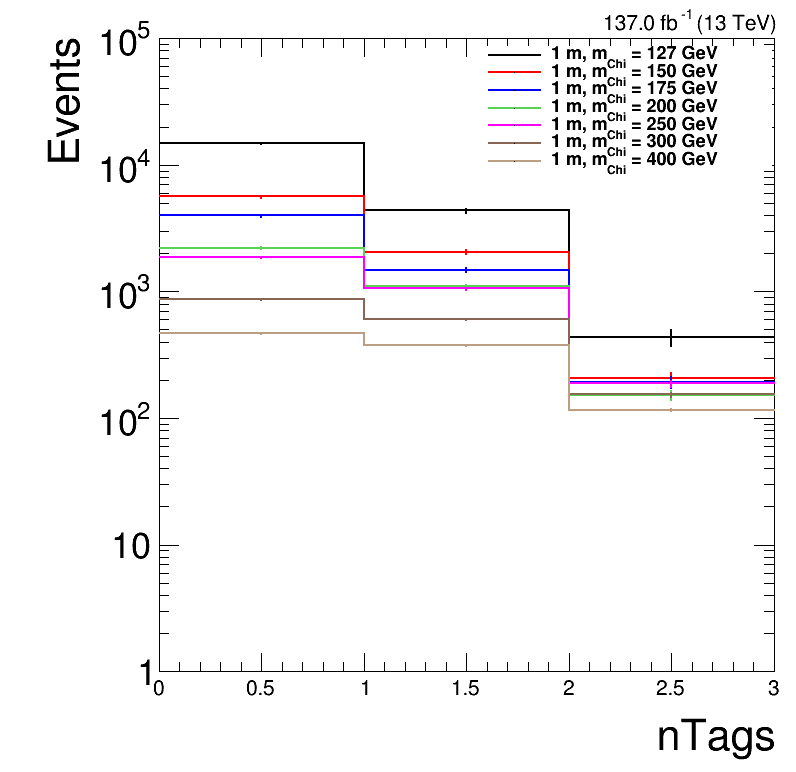

In [107]:
# Plotting  
c = rt.TCanvas('c','c', 800, 800)
ht = {}
leg = rt.TLegend(0.60,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


color_list = [845,806,861,876,597,625]

i=0
for k,v in tree.items():
    print(k,v)
    
    var = nTags[k]
    ws = trg_jet_w[k]*trg_jet_puw[k]
    axis_set = ['nTags', 'Events']
    bin_set = [3,0,3]
    lumi=137000
    
    ht[k] = create_TH1D( var, axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
    ht[k].SetLineColor(std_color_list[i])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetRangeUser(1,1e+5)
    print(k, std_color_list[i])
    ht[k].Draw("hist E same")
    leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  
    
    i+=1
    
CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
CMS_lumi.cmsText = ""
CMS_lumi.writeExtraText = False
CMS_lumi.CMS_lumi(c,4,3)

leg.Draw()
c.SetLeftMargin(0.2)
c.SetRightMargin(0.027)
c.SetLogy()
c.Draw()
outf='nTags.png'
c.SaveAs(plotDir+outf)    
    

# Signal Yields

In [105]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Weight' , 'Bin 2 Yield', 'Bin 2 Error'])
for k,v in tree.items():
#     if '2016' in k:
#         lumi=35922
#     elif '2017' in k:
#         lumi=41529
#     elif '2018' in k:
#         lumi=59740
    lumi=137000
#     print(k)
#     EventW =  trg_jet_w[k][nTags[k]==2] 
#     EventW = [x*y for x,y in zip(trg_jet_w[k][nTags[k]<3],trg_jet_puw[k][nTags[k]<3])]
    print(len(nTags[k]))
    print(len(trg_fatjet_pt[k]))
    print(len(trg_jet_w[k]))
    sel_str = np.logical_and(nTags[k]==2, trg_fatjet_pt[k][trg_fatjet_pt[k]>fatjet_pt_cut].count()==0)
    EventW = [x*y for x,y in zip(trg_jet_w[k][sel_str],trg_jet_puw[k][sel_str])]
#     EventW = [x*y for x,y in zip(trg_jet_w[k][trg_fatjet_pt[k][trg_fatjet_pt[k]>fatjet_pt_cut].count()==0],trg_jet_puw[k][trg_fatjet_pt[k][trg_fatjet_pt[k]>fatjet_pt_cut].count()==0])]
#     EventW = [x*y for x,y in zip(trg_jet_w[k],trg_jet_puw[k])]
    EventWsq = [x*x  for x in EventW]
#     print(np.sum(EventW)*lumi)
    print(np.sum(EventW)*1)
#     print(len(EventW))
#     print(len(trg_jet_w[k][nTags[k]==2]))
#     row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(trg_jet_w[k][nTags[k]==2])*lumi, 2), round(math.sqrt(np.sum(trg_jet_w[k][nTags[k]==2])*lumi), 2) ]
#     row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventW)*lumi), 2) ]
    row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2) ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
2415
2415
2415
0.0021192035637795925
2522
2522
2522
0.0006820971611887217
2586
2586
2586
0.0006582339410670102
3021
3021
3021
0.00037460352177731693
4282
4282
4282
0.00047388975508511066
6145
6145
6145
0.00029472948517650366
10994
10994
10994
0.00021872410434298217
+--------+-----------------+-------------+-------------+
| Sample |      Weight     | Bin 2 Yield | Bin 2 Error |
+--------+-----------------+-------------+-------------+
|  127   | [5.6951445e-05] |    290.33   |    53.67    |
|  150   | [2.1877613e-05] |    93.45    |     18.8    |
|  175   | [1.5398517e-05] |    90.18    |    15.38    |
|  200   |  [8.116029e-06] |    51.32    |     8.44    |
|  250   | [5.1101733e-06] |    64.92    |     7.45    |
|  300   | [1.8683509e-06] |    40.38    |     3.55    |
|  400   |  [6.086827e-07] |    29.97    |     1.71    |
+--------+-----------------+-------------+-------------+


In [106]:
table_txt = table.get_string()
# with open(plotDir+'/467SignalSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/310SignalSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/1m_200GeV_467SignalSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/10m_200GeV_467SignalSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/SignalSummaryTableBin2Rebin.txt','w') as file:
with open(plotDir+'/ResolvedBin2_fatjet'+str(fatjet_pt_cut)+'_SignalSummaryTable.txt','w') as file:
# with open(plotDir+'/Resolved_fatjet300_SignalSummaryTableBin2Rebin.txt','w') as file:
    file.write(table_txt)

In [77]:
# from prettytable import PrettyTable
# print('\n\n======================= Summary ==============================')
# table =  PrettyTable(['Sample', 'Weight' , 'AK8 Yield', 'AK8 Error'])
# for k,v in tree.items():
 
#     lumi=137000
 
#     EventW = [x*y for x,y in zip(trg_jet_w[k][trg_fatjet_pt[k].count()>0],trg_jet_puw[k][trg_fatjet_pt[k].count()>0])]
# #     EventW = [x*y for x,y in zip(trg_jet_w[k][trg_fatjet_pt[k].count()==0],trg_jet_puw[k][trg_fatjet_pt[k].count()==0])]
#     EventWsq = [x*x  for x in EventW]
#     row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2) ]
#     table.add_row(row)
        
# print(table)

In [78]:
# table_txt = table.get_string()
# with open(plotDir+'/Boosted_fatjet250_SignalSummaryTableBin2Rebin.txt','w') as file:
# # with open(plotDir+'/Boosted_fatjet300_SignalSummaryTableBin2Rebin.txt','w') as file:
#     file.write(table_txt)